# CNN Transfer Learning Results

In [47]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
# Number of worker nodes
n_workers = 8
n_workers_list = [4, 8]

# Hyperparameters H
buffer_len = 50
mini_batch_size = 25

# Number of runs
n_runs = 100

## Load the saved results

In [49]:
# CIFAR-10
try:
    with open("out/full_network/cifar10.pkl", "rb") as f:
        res_cifar_fn = pickle.load(f)
        print("Full-network cifar10 results file loaded")
except FileNotFoundError:
    print("Full-network cifar10 results file NOT found")

try:
    with open("out/single_layers/cifar10.pkl", "rb") as f:
        res_cifar_sl = pickle.load(f)
        print("Single-layer cifar10 results file loaded")
except FileNotFoundError:
    print("Single-layer cifar10 results file NOT found")

# Fashion MNIST
try:
    with open("out/full_network/fmnist.pkl", "rb") as f:
        res_fmnist_fn = pickle.load(f)
        print("Full-network fmnist results file loaded")
except FileNotFoundError:
    print("Full-network fmnist results file NOT found")

try:
    with open("out/single_layers/fmnist.pkl", "rb") as f:
        res_fmnist_sl = pickle.load(f)
        print("Single-layer fmnist results file loaded")
except FileNotFoundError:
    print("Single-layer fmnist results file NOT found")

# Fashion MNIST diff workers
res_fmnist_fn_diff_workers, res_fmnist_sl_diff_workers, res_fmnist_fedavg_diff_workers = {}, {}, {}
for n_worker in n_workers_list:
    try:
        with open(f"out/fedavg/fmnist_{n_worker}.pkl", "rb") as f:
            res_fmnist_fedavg_diff_workers[n_worker] = pickle.load(f)
            print("Full-network fmnist results file loaded")
    except FileNotFoundError:
        print("Full-network fmnist results file NOT found")

    try:
        with open(f"out/single_layers/fmnist_{n_worker}.pkl", "rb") as f:
            res_fmnist_sl_diff_workers[n_worker] = pickle.load(f)
            print("Single-layer fmnist results file loaded")
    except FileNotFoundError:
        print("Single-layer fmnist results file NOT found")
    
    try:
        with open(f"out/full_network/FAKEfmnist_{n_worker}.pkl", "rb") as f:
            res_fmnist_fn_diff_workers[n_worker] = pickle.load(f)
            print("Full-network fmnist results file loaded")
    except FileNotFoundError:
        print("Full-network fmnist results file NOT found")

Full-network cifar10 results file loaded
Single-layer cifar10 results file loaded
Full-network fmnist results file loaded
Single-layer fmnist results file loaded
Full-network fmnist results file loaded
Single-layer fmnist results file loaded
Full-network fmnist results file loaded
Full-network fmnist results file loaded
Single-layer fmnist results file loaded
Full-network fmnist results file loaded


## Plots

### Box Plots

#### Prepare the data

In [50]:
def prepare_results_boxplot(res_sl, res_fn, lrs_inv):
    acc_max_sl = {}
    acc_max_fn = {}
    for lr_inv in lrs_inv:
        acc_max_sl[lr_inv] = [np.max(res_sl[lr_inv][0][i]) for i in range(n_runs)]
        acc_max_fn[lr_inv] = [np.max(res_fn[lr_inv][0][i]) for i in range(n_runs)]

    # Prepare data for plotting
    df = pd.DataFrame(columns=['lr', 'acc', 'workers'])
    for lr_inv in lrs_inv:
        df = pd.concat([df, pd.DataFrame({'lr': lr_inv, 'acc': acc_max_sl[lr_inv], 'Implementation': 'Single-layer'})], ignore_index=True)
        df = pd.concat([df, pd.DataFrame({'lr': lr_inv, 'acc': acc_max_fn[lr_inv], 'Implementation': 'Full-network'})], ignore_index=True)
    
    return df

#### CIFAR-10

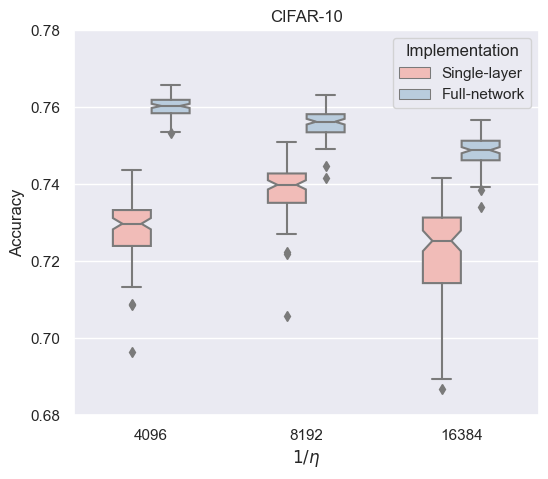

In [51]:
fig = plt.figure(figsize=(6,5))
sns.set(style="darkgrid")

lrs_inv_cifar = [4096, 8192, 16384]
df_mnist = prepare_results_boxplot(res_cifar_sl, res_cifar_fn, lrs_inv_cifar)

# Grouped violinplot
ax = sns.boxplot(data=df_mnist, x='lr', y='acc', hue=r"Implementation", palette="Pastel1", notch=True, width=0.5)
ax.set_title("CIFAR-10")
ax.set(ylabel='Accuracy', xlabel=r"$1/\eta$")
ax.set_ylim([0.68, 0.78])
plt.show()

#### Fashion MNIST

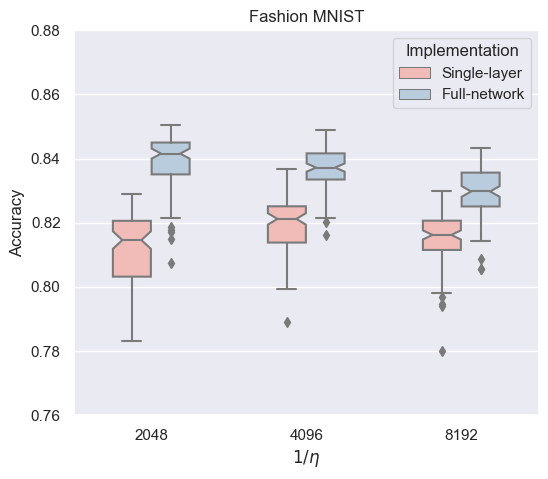

In [52]:
fig = plt.figure(figsize=(6,5))
sns.set(style="darkgrid")

lrs_inv_fmnist = [2048, 4096, 8192]
df_fmnist = prepare_results_boxplot(res_fmnist_sl, res_fmnist_fn, lrs_inv_fmnist)

# Grouped violinplot
ax = sns.boxplot(data=df_fmnist, x='lr', y='acc', hue=r"Implementation", palette="Pastel1", notch=True, width=0.5)
ax.set_title("Fashion MNIST")
ax.set(ylabel='Accuracy', xlabel=r"$1/\eta$")
ax.set_ylim([0.76, 0.88])
plt.show()

### Number of Workers

#### Prepare the data

In [53]:
lrs = [0.1, 0.05, 0.01]

fedavg_accs = {}
for n_worker in n_workers_list:
    fedavg_accs[n_worker] = {}
    for lr in lrs:
        fedavg_accs[n_worker][lr] = [np.mean(k) for k in zip(*res_fmnist_fedavg_diff_workers[n_worker][lr][0])]

fn_accs = {}
for n_worker in n_workers_list:
    fn_accs[n_worker] = {}
    for lr_inv in lrs_inv_fmnist:
        fn_accs[n_worker][lr_inv] = [np.mean(k) for k in zip(*res_fmnist_fn_diff_workers[n_worker][lr_inv][0])]

sl_accs = {}
for n_worker in n_workers_list:
    sl_accs[n_worker] = {}
    for lr_inv in lrs_inv_fmnist:
        sl_accs[n_worker][lr_inv] = [np.mean(k) for k in zip(*res_fmnist_sl_diff_workers[n_worker][lr_inv][0])]

In [54]:
fedavg = [round(np.max([fedavg_accs[w][lr] for lr in lrs]), 3) for w in n_workers_list]
fn = [round(np.max([fn_accs[w][lr_inv] for lr_inv in lrs_inv_fmnist]), 3) for w in n_workers_list]
sl = [round(np.max([sl_accs[w][lr_inv] for lr_inv in lrs_inv_fmnist]), 3) for w in n_workers_list]
x = [4, 8, 16, 32, 64, 128]

df_fedavg = pd.DataFrame(columns=['acc', 'workers'])
df_fn = pd.DataFrame(columns=['acc', 'workers'])
df_sl = pd.DataFrame(columns=['acc', 'workers'])

for i in range(len(fedavg)):
    df_fedavg = pd.concat([df_fedavg, pd.DataFrame({'acc': [fedavg[i]], 'Implementation': 'Floating-point FedAvg', 'workers': x[i]})], ignore_index=True)
    df_fn = pd.concat([df_fn, pd.DataFrame({'acc': [fn[i]], 'Implementation': 'Single-layer TIFeD', 'workers': x[i]})], ignore_index=True)
    df_sl = pd.concat([df_sl, pd.DataFrame({'acc': [sl[i]], 'Implementation': 'Full-network TIFeD', 'workers': x[i]})], ignore_index=True)

#### Plot

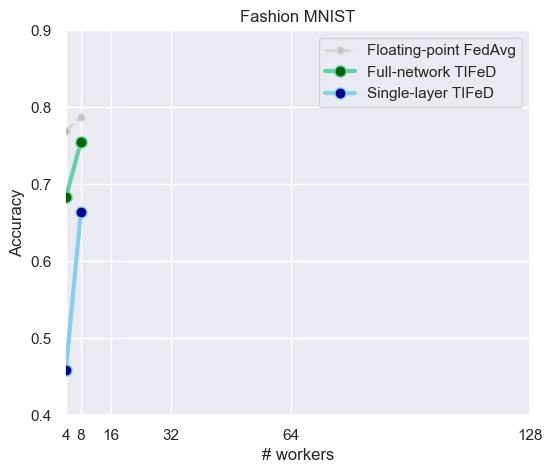

In [55]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(6,5))

# plot
plt.plot('workers', 'acc', data=df_fedavg, marker='o', markerfacecolor='silver', markersize=5, color='lightgrey', linewidth=2, linestyle="dashed", label='Floating-point FedAvg')
plt.plot('workers', 'acc', data=df_fn, marker='o', markerfacecolor='darkgreen', markersize=8, color='mediumaquamarine', linewidth=3, label='Full-network TIFeD')
plt.plot('workers', 'acc', data=df_sl, marker='o', markerfacecolor='darkblue', markersize=8, color='skyblue', linewidth=3, label='Single-layer TIFeD')

plt.title('Fashion MNIST')
plt.xlabel(xlabel='# workers')
plt.ylabel('Accuracy')

plt.xticks(x)
plt.ylim([0.4, 0.9])
plt.legend()
plt.show()